In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import os
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

Load Dataset

In [13]:
folder_path = "../Datasets/UTK_Dataset/UTKFace" 
file_names = os.listdir(folder_path)

data = []

for name in file_names:
    
    parts = name.split('_')
    
    if len(parts) > 1:
        age = int(parts[0]) 
        data.append({
            'image_path': os.path.join(folder_path, name),
            'age': age
        })

# Now you have a clean table!
df = pd.DataFrame(data)
print(df.head())

                                          image_path  age
0  ../Datasets/UTK_Dataset/UTKFace\100_0_0_201701...  100
1  ../Datasets/UTK_Dataset/UTKFace\100_0_0_201701...  100
2  ../Datasets/UTK_Dataset/UTKFace\100_1_0_201701...  100
3  ../Datasets/UTK_Dataset/UTKFace\100_1_0_201701...  100
4  ../Datasets/UTK_Dataset/UTKFace\100_1_0_201701...  100


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  23708 non-null  object
 1   age         23708 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


In [15]:
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [16]:
df.value_counts().sum()

23708

In [17]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        
        image = Image.open(img_path).convert('RGB')
        
        
        age = float(img_name.split('_')[0])
        
        if self.transform:
            image = self.transform(image)
            
        
        return image, torch.tensor([age], dtype=torch.float32)

In [18]:
class AgeRegressionCNN(nn.Module):
    def __init__(self):
        super(AgeRegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128) 
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        return x

In [19]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = UTKFaceDataset(root_dir='../Datasets/UTK_Dataset/UTKFace', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

data_iter = iter(train_loader)
images, ages = next(data_iter)

print(f"Batch Shape: {images.shape}") 

print(f"Single Image Shape: {images[0].shape}")

Batch Shape: torch.Size([32, 3, 128, 128])
Single Image Shape: torch.Size([3, 128, 128])


Model,Loss,Optimizer Setup

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeRegressionCNN().to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [21]:
for epoch in range(10):
    running_loss = 0.0
   
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/10]", leave=True)
    
    for images, ages in loop:
        images, ages = images.to(device), ages.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        
        batch_loss = loss.item()
        running_loss += batch_loss
        
       
        loop.set_postfix(loss=batch_loss)
    
    print(f"Epoch {epoch+1} Completed. Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10]: 100%|██████████| 741/741 [12:15<00:00,  1.01it/s, loss=165]  


Epoch 1 Completed. Avg Loss: 204.0027


Epoch [2/10]: 100%|██████████| 741/741 [12:09<00:00,  1.02it/s, loss=139] 


Epoch 2 Completed. Avg Loss: 119.0164


Epoch [3/10]: 100%|██████████| 741/741 [07:58<00:00,  1.55it/s, loss=40.1]


Epoch 3 Completed. Avg Loss: 95.2545


Epoch [4/10]: 100%|██████████| 741/741 [07:39<00:00,  1.61it/s, loss=87.8]


Epoch 4 Completed. Avg Loss: 80.8475


Epoch [5/10]: 100%|██████████| 741/741 [07:43<00:00,  1.60it/s, loss=70.9]


Epoch 5 Completed. Avg Loss: 65.6922


Epoch [6/10]: 100%|██████████| 741/741 [06:56<00:00,  1.78it/s, loss=52.7]


Epoch 6 Completed. Avg Loss: 54.7365


Epoch [7/10]: 100%|██████████| 741/741 [08:01<00:00,  1.54it/s, loss=56.9]


Epoch 7 Completed. Avg Loss: 45.2294


Epoch [8/10]: 100%|██████████| 741/741 [08:06<00:00,  1.52it/s, loss=23.1]


Epoch 8 Completed. Avg Loss: 38.1199


Epoch [9/10]: 100%|██████████| 741/741 [07:45<00:00,  1.59it/s, loss=31.7]


Epoch 9 Completed. Avg Loss: 30.7884


Epoch [10/10]: 100%|██████████| 741/741 [07:45<00:00,  1.59it/s, loss=14.8]

Epoch 10 Completed. Avg Loss: 25.2418


Testing Loop

In [22]:
model.eval()  
test_loss = 0.0

with torch.no_grad():
    test_loop = tqdm(test_loader, desc="Testing", leave=True)
    for images, ages in test_loop:
        images, ages = images.to(device), ages.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, ages)
        
        test_loss += loss.item()
        test_loop.set_postfix(loss=loss.item())

print(f"Final Test MSE Loss: {test_loss/len(test_loader):.4f}")

Testing: 100%|██████████| 741/741 [03:46<00:00,  3.27it/s, loss=12.6]

Final Test MSE Loss: 21.8211


Visualizations


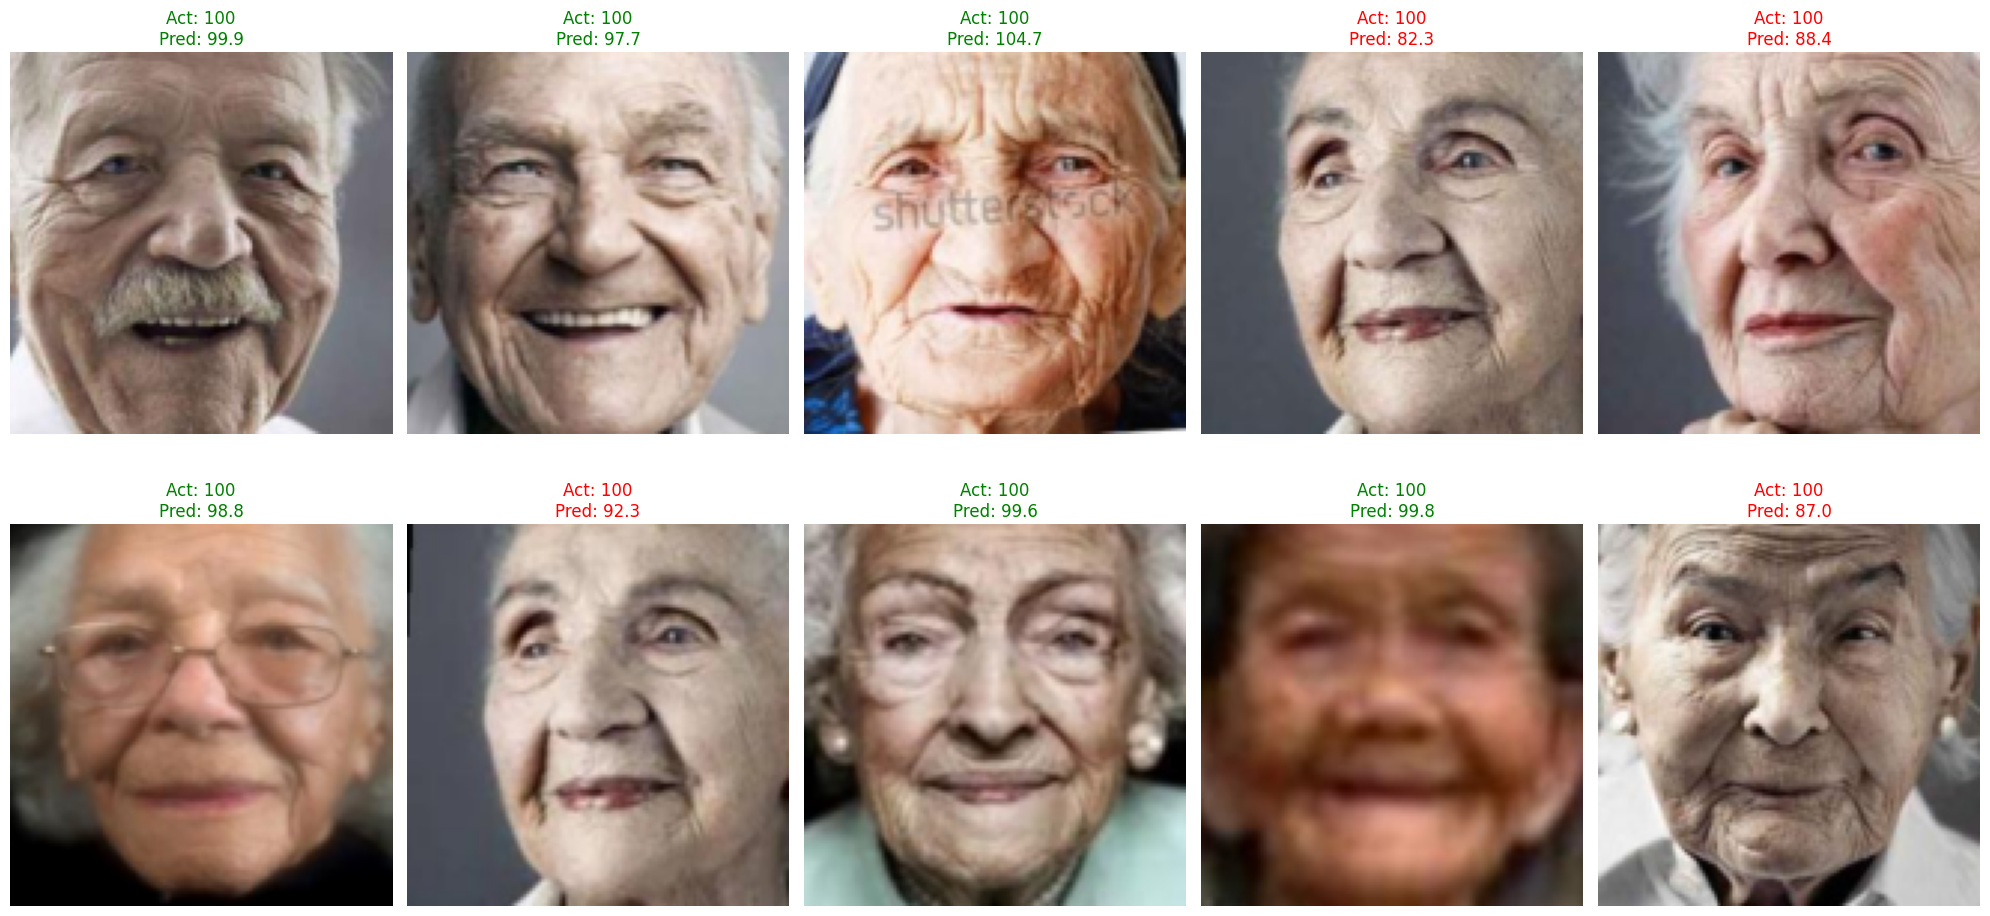

In [24]:
def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(20, 10)) 

    with torch.no_grad():
        for images, ages in test_loader:
            images, ages = images.to(device), ages.to(device)
            outputs = model(images)
            
            
            images = images.cpu()
            ages = ages.cpu().numpy()
            outputs = outputs.cpu().numpy()

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                
                plt.subplot(2, 5, images_shown + 1)
                
                
                img = images[i].permute(1, 2, 0).numpy()
                img = img * 0.5 + 0.5 
                img = np.clip(img, 0, 1)

                actual = int(ages[i][0])
                predicted = outputs[i][0]
                
                plt.imshow(img)
                
                color = 'green' if abs(actual - predicted) <= 5 else 'red'
                
                plt.title(f"Act: {actual}\nPred: {predicted:.1f}", color=color, fontsize=12)
                plt.axis('off')
                
                images_shown += 1
            
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_loader, device, num_images=10)

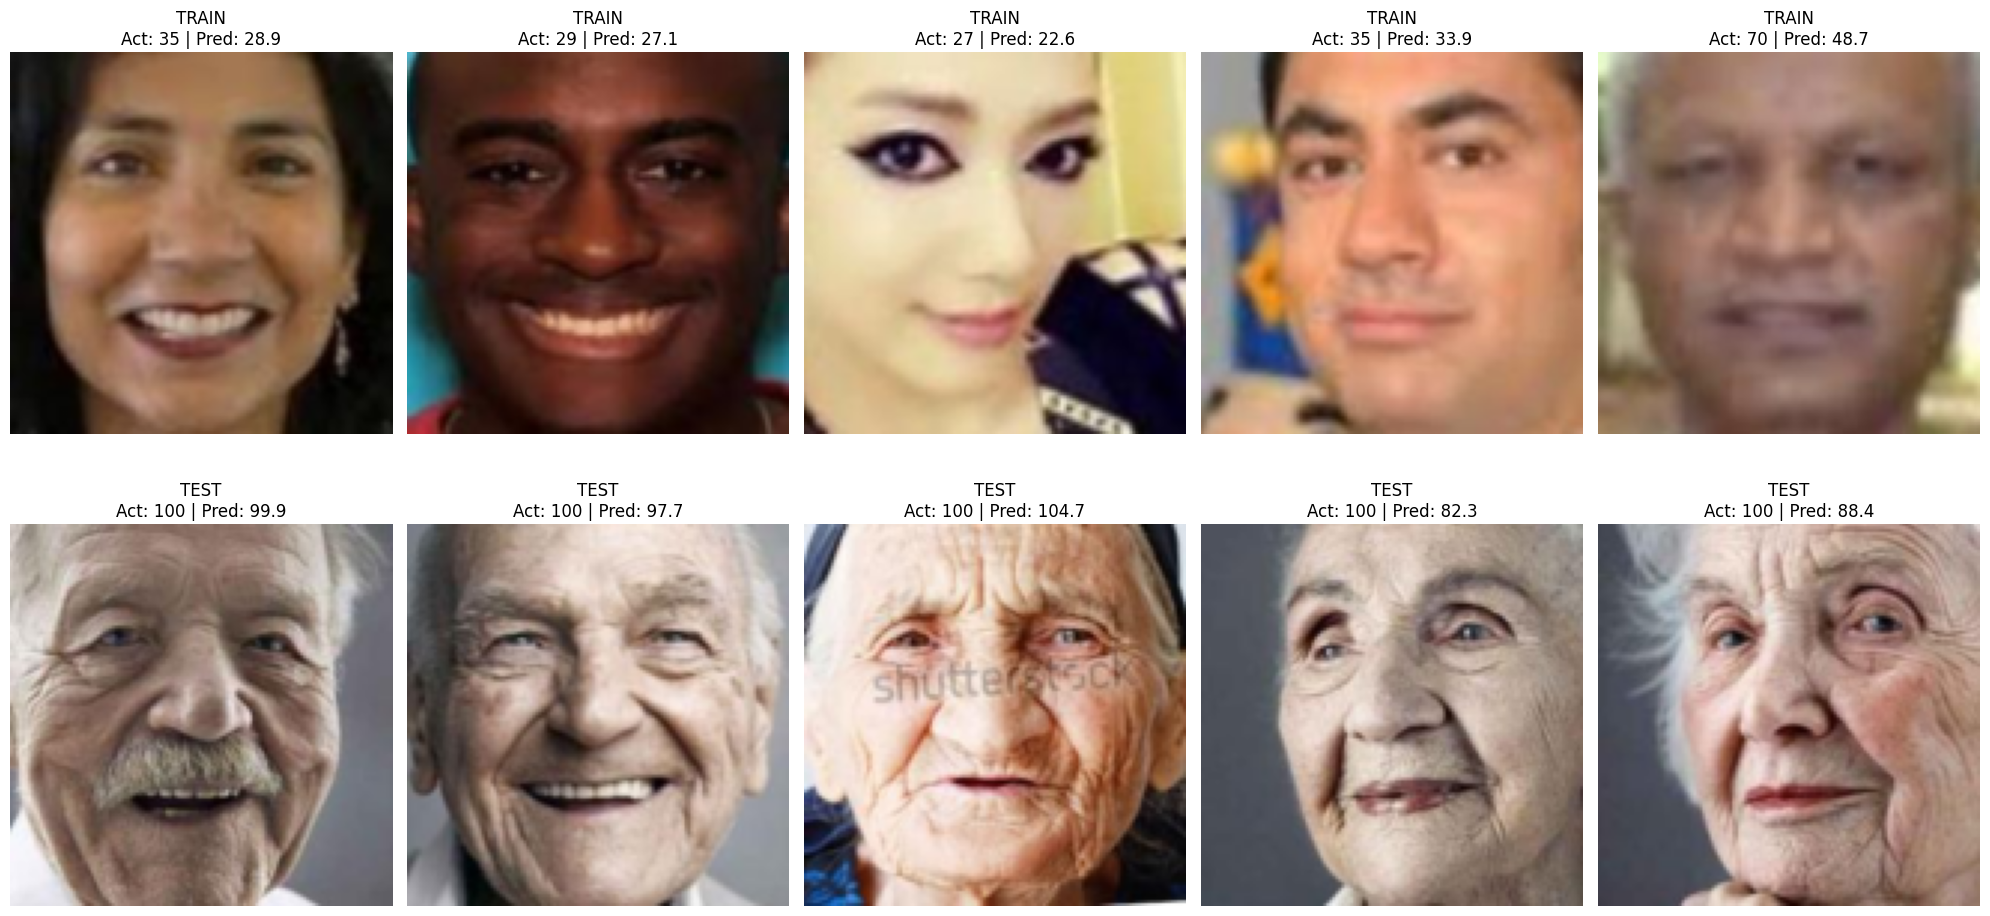

In [25]:
def compare_train_test(model, train_loader, test_loader, device):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    
    
    def plot_row(loader, row_idx, title_prefix):
        images, ages = next(iter(loader))
        images, ages = images.to(device), ages.to(device)
        with torch.no_grad():
            outputs = model(images)
        
        for i in range(5):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img * 0.5 + 0.5, 0, 1) 
            
            actual = int(ages[i][0])
            pred = outputs[i][0].item()
            
            axes[row_idx, i].imshow(img)
            axes[row_idx, i].set_title(f"{title_prefix}\nAct: {actual} | Pred: {pred:.1f}")
            axes[row_idx, i].axis('off')

    plot_row(train_loader, 0, "TRAIN")
    plot_row(test_loader, 1, "TEST")
    
    plt.tight_layout()
    plt.show()

compare_train_test(model, train_loader, test_loader, device)

Plotting the Loss Curve

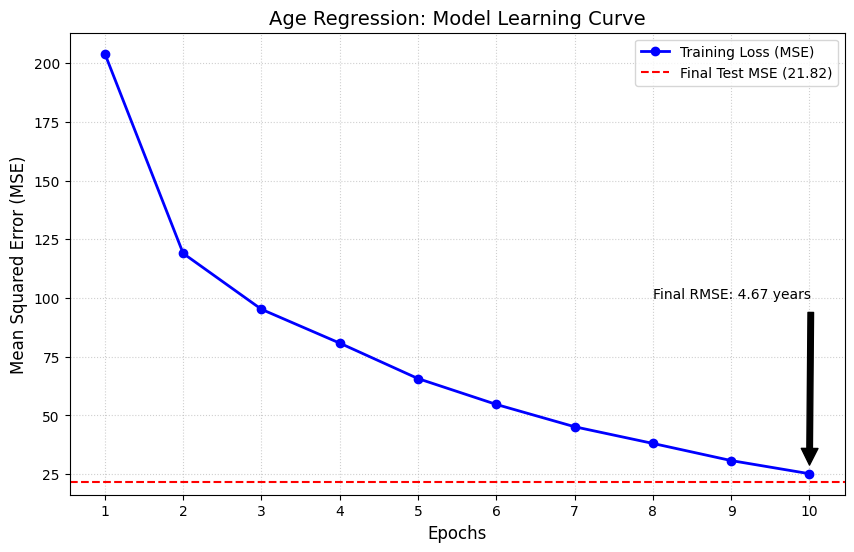

In [26]:
epochs = range(1, 11)
train_losses = [204.0, 119.0, 95.2, 80.8, 65.7, 54.7, 45.2, 38.1, 30.8, 25.2]
test_mse = 21.82  

plt.figure(figsize=(10, 6))


plt.plot(epochs, train_losses, label='Training Loss (MSE)', color='blue', marker='o', linewidth=2)


plt.axhline(y=test_mse, color='red', linestyle='--', label=f'Final Test MSE ({test_mse:.2f})')


plt.title('Age Regression: Model Learning Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()


plt.annotate(f'Final RMSE: {test_mse**0.5:.2f} years', 
             xy=(10, train_losses[-1]), xytext=(8, 100),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

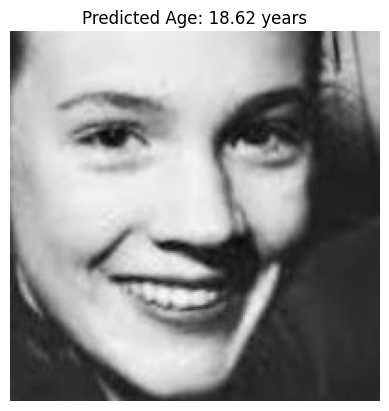

The model thinks this person is 18.6 years old but the actual age is 25 years old.


In [29]:
def predict_single_image(model, image_path, transform, device):
    
    img = Image.open(image_path).convert('RGB')
    
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)
    
    predicted_age = prediction.item()
    
    
    plt.imshow(img)
    plt.title(f"Predicted Age: {predicted_age:.2f} years")
    plt.axis('off')
    plt.show()
    
    return predicted_age


image_to_test = "../Datasets/UTK_Dataset/UTKFace/25_1_0_20170116223120888.jpg.chip.jpg" 
age = predict_single_image(model, image_to_test, transform, device)
print(f"The model thinks this person is {age:.1f} years old but the actual age is 25 years old.")